In [1]:
import cv2
import gym
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
from sys import getsizeof
import time
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from tqdm import tqdm

In [2]:
from causal_world.task_generators.task import generate_task
from causal_world.envs.causalworld import CausalWorld


In [3]:
class FrameStack(gym.Wrapper):
    
    """
    stack multiple frames together 
    as done in the Nature paper and later work.
    allow for single goal observation, i.e,
    get a single frame of goal obs for each view, 
    because the consecutive frames of goal obs does not provide
    dynamic information to the agent, i.e, goal object doesn't move
    
    

    :param env: Environment to wrap
    :param k: frames that stack together
    :param single_goal_obs: flag that control how many 
     frames of goal obs to stack
    """
    def __init__(self, env, k, single_goal_obs = True):
        gym.Wrapper.__init__(self, env)
        self._k = k
        self.single_goal_obs = single_goal_obs
        self._frames = deque([], maxlen=k)
        self.shp = env.observation_space.shape
        self.num_view = int(self.shp[0]/2)
        # default channel is 1 (for Grayscale obs)
        self.num_channel = 1                   
        
        # reshape of the obs if it's RGB and 
        # change the number of channel 
        if len(self.shp) == 4:
            self.shp = (self.shp[0] * self.shp[-1], self.shp[1], self.shp[2])
            self.num_channel = 3
            
        if self.single_goal_obs:
            shape = ((self.num_view * self.num_channel * (k + 1),) + self.shp[1:])
        else:
            shape = ((self.shp[0] * k,) + self.shp[1:])
        self.observation_space = gym.spaces.Box(
            low=0,
            high=1,
            shape=shape,
            dtype=env.observation_space.dtype
        )
        

    def reset(self):
        obs = self.env.reset()
        # reshape the initial obs
        obs = obs.reshape(self.shp)
        for _ in range(self._k):
            self._frames.append(obs)
        return self._get_obs()

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
         # reshape the obs
        obs = obs.reshape(self.shp)
        self._frames.append(obs)
        return self._get_obs(), reward, done, info

    def _get_obs(self):
        assert len(self._frames) == self._k
        
        frames_target = []
        frames_goal = []
        # extract the target obs and goal obs to seperate list 
        for i in range(self._k):
            for j in range(self.shp[0]):
                if j < self.shp[0]/2:
                    frames_target.append(self._frames[i][j])
                else:
                    frames_goal.append(self._frames[i][j])
        # merge the two target obs list and goal obs list
        # each element in the list is multiple views of the object 
        last_frames = []
        if self.single_goal_obs:
            # only merge one frame from different view of goal
            for i in range(int(len(frames_goal)/self._k)):
                last_frames.append(frames_goal[i])
        else:
            last_frames = frames_goal
        return np.concatenate((frames_target,last_frames), axis=0)

In [4]:
class ResizeFrame(gym.ObservationWrapper):
    """
    warp frames to 84x84 (default)
    as done in the Nature paper and later work.

    :param env: Environment to wrap
    :param width: New frame width
    :param height: New frame height
    """

    def __init__(self, env: gym.Env, max_episode_length, width: int = 84, height: int = 84) -> None:
        super().__init__(env)
        self.width = width
        self.height = height
        assert isinstance(env.observation_space, gym.spaces.Box), f"Expected Box space, got {env.observation_space}"
        #self._max_episode_steps = max_episode_length
        if len(env.observation_space.shape) == 4:
            self.observation_space = gym.spaces.Box(
                low=0,
                high=1,
                shape=(env.observation_space.shape[0], self.height, self.width, env.observation_space.shape[-1]),
                dtype=env.observation_space.dtype,  # type: ignore[arg-type]
            )
        if len(env.observation_space.shape) == 3:
            self.observation_space = gym.spaces.Box(
                low=0,
                high=1,
                shape=(env.observation_space.shape[0], self.height, self.width),
                dtype=env.observation_space.dtype,  # type: ignore[arg-type]
            )
        

    def observation(self, frame: np.ndarray) -> np.ndarray:
        """
        returns the current observation from a frame

        :param frame: environment frame
        :return: the observation
        """
        assert cv2 is not None, "OpenCV is not installed, you can do `pip install opencv-python`"
        
        new_frame = np.empty(self.observation_space.shape, dtype = self.observation_space.dtype)
        for i in range(len(frame)):
            new_frame[i] = cv2.resize(frame[i], (self.width, self.height), interpolation=cv2.INTER_AREA)
        return new_frame

In [5]:
class GrayFrame(gym.ObservationWrapper):
    """
    Convert frames to gray scale (default)
    as done in the Nature paper and later work.

    :param env: Environment to wrap
    :param width: New frame width
    :param height: New frame height
    """

    def __init__(self, env: gym.Env, max_episode_length) -> None:
        super().__init__(env)
        assert isinstance(env.observation_space, gym.spaces.Box), f"Expected Box space, got {env.observation_space}"
        
        #self._max_episode_steps = max_episode_length
        if len(env.observation_space.shape) == 3:
            return
        self.observation_space = gym.spaces.Box(
            low=0,
            high=1,
            shape= env.observation_space.shape[:3],
            dtype=env.observation_space.dtype,  # type: ignore[arg-type]
        )
        

    def observation(self, frame: np.ndarray) -> np.ndarray:
        """
        returns the current observation from a frame

        :param frame: environment frame
        :return: the observation
        """
        assert cv2 is not None, "OpenCV is not installed, you can do `pip install opencv-python`"
        
        if self.observation_space.dtype != 'uint8':
            frame = np.float32(frame)
        new_frame = np.empty(self.observation_space.shape, dtype = self.observation_space.dtype)
        for i in range(len(frame)):
            new_frame[i] = cv2.cvtColor(frame[i], cv2.COLOR_RGB2GRAY) 


        return new_frame    

In [6]:
# adapted from stable_baselines3/common/atari_wrappers.py

class DtypeChange(gym.ObservationWrapper):
    """
    Convert data type to uint8 (default)

    :param env: Environment to wrap
    :param type: data type

    """

    def __init__(self, env: gym.Env, dtype = 'uint8') -> None:
        super().__init__(env)
        assert isinstance(env.observation_space, gym.spaces.Box), f"Expected Box space, got {env.observation_space}"
        
        if len(env.observation_space.shape) == 3:
            return
        self.observation_space = gym.spaces.Box(
            low=0,
            high=1,
            shape= env.observation_space.shape,
            dtype=dtype,  # type: ignore[arg-type]
        )
        

    def observation(self, frame: np.ndarray) -> np.ndarray:
        """
        returns the current observation from a frame

        :param frame: environment frame
        :return: the observation
        """
        assert cv2 is not None, "OpenCV is not installed, you can do `pip install opencv-python`"
        
        frame = frame * 255
        frame = frame.astype(np.uint8)

        return frame

In [7]:
def make_env(task_name, skip_frame, seed, maximum_episode_length, observation_mode, capture_video, run_name):
    def thunk():
        
        task = generate_task(task_generator_id=task_name,dense_reward_weights=np.array([2500, 2500, 0]),
                      fractional_reward_weight=100)
        
        #piking task
        #task = generate_task(task_generator_id=task_name,
        #                  dense_reward_weights=np.array(
        #                      [250, 0, 125, 0, 750, 0, 0, 0.005]),
        #                  fractional_reward_weight=1,
        #                  tool_block_mass=0.02)
        if capture_video:
            env = CausalWorld(task=task, skip_frame=skip_frame, seed=seed, max_episode_length = maximum_episode_length, observation_mode = observation_mode, render_mode="rgb_array")
            # record the video every 250 episode
            env = gym.wrappers.RecordVideo(env, f"video/{run_name}", episode_trigger = lambda x: x % 250 == 0)
        else:
            env = CausalWorld(task=task, skip_frame=skip_frame, seed=seed,  max_episode_length = maximum_episode_length, observation_mode = observation_mode, camera_indicies = [0])
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env = DtypeChange(env)
        env = GrayFrame(env, max_episode_length=maximum_episode_length)
        #env = ResizeFrame(env, max_episode_length=maximum_episode_length, width=84, height=84)
        env = FrameStack(env, k=3, single_goal_obs=True)
        

        env.seed(seed)
        # sample random action in exploration phase
        env.action_space.seed(seed)
        #env.observation_space.seed(seed)
        return env
    return thunk

In [8]:
class replayBuffer():
    def __init__(self, obs_space, obs_dim, act_space, act_dim, capacity, device):
        self.device = device
        self.capacity = capacity
        self.obs_space = obs_space
        self.act_space = act_space
        self.obs_buffer = np.zeros((tuple([capacity]) + obs_dim), dtype=self.obs_space)
        self.next_obs_buffer = np.zeros((tuple([capacity]) + obs_dim), dtype=self.obs_space)
        self.act_buffer = np.zeros((capacity, act_dim), dtype=self.act_space)
        self.r_buffer = np.zeros(capacity, dtype=np.float32)
        self.done_buffer = np.zeros(capacity, dtype=np.float32)

        self.ptr = 0
        self.current_size = 0

    def store(self, obs, act, r, next_obs, done):
        
        # flattent the observation 
        # doesn't support parallel envs
        #obs.flatten()
        #next_obs.flatten()

        self.obs_buffer[self.ptr] = obs
        self.act_buffer[self.ptr] = act
        self.r_buffer[self.ptr] = r
        self.next_obs_buffer[self.ptr] = next_obs
        self.done_buffer[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.capacity
        self.current_size = min(self.current_size + 1, self.capacity)

    def sample(self, batch_size=32):
        idx = np.random.randint(0, self.current_size, size=batch_size)
        # the reward is rescaled
        batch = dict(
            obs = self.obs_buffer[idx],
            act = self.act_buffer[idx],
            r = self.r_buffer[idx],
            next_obs = self.next_obs_buffer[idx],
            done = self.done_buffer[idx]
        )   
        
        return batch
    
    def shuffle(self):
        # Generate a shuffled index array
        idx = np.arange(self.current_size)
        np.random.shuffle(idx)

        # Reorder all buffers according to the shuffled indices
        self.obs_buffer[:self.current_size] = self.obs_buffer[idx]
        self.next_obs_buffer[:self.current_size] = self.next_obs_buffer[idx]
        self.act_buffer[:self.current_size] = self.act_buffer[idx]
        self.r_buffer[:self.current_size] = self.r_buffer[idx]
        self.done_buffer[:self.current_size] = self.done_buffer[idx]

In [9]:
def plot_obs(obs, num_view, RGB=False):
    fig = plt.figure(figsize=(10, 15)) 
    if len(obs.shape)==4:
        obs = obs[0]
    if RGB:
        num_fig = int(obs.shape[0] / 3)
        obs = obs.reshape(num_fig, 84, 84, 3)
    else:
        num_fig = obs.shape[0]
    
    rows = int(num_fig / num_view)
    columns = num_view

    for i in range(num_fig):
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(obs[i])

In [10]:
envs = gym.vector.SyncVectorEnv([make_env('pushing', 3, i, 600, 'pixel', False, 'dump') for i in range(1)]) 

In [12]:
torch.cuda.device_count()

1

## check the replay buffer

In [13]:
start = time.time()
obs = envs.reset()
print(f"size of single observation: {getsizeof(obs)}")

rep_buffer = replayBuffer(envs.single_observation_space.dtype, envs.single_observation_space.shape, 
                          envs.single_action_space.dtype, envs.single_action_space.shape[0],
                          capacity=110000, device='cpu')
final_obs = []
for i in tqdm(range(10000)):
    a = np.array([envs.single_action_space.sample()])
    next_obs, r, done,infos = envs.step(a)
   
    
    #handle the terminal observation
    real_next_obs = next_obs.copy()
    for idx, d in enumerate(done):
        if d:
            real_next_obs[idx] = infos["final_observation"][idx]
            final_obs.append(real_next_obs)
    
    rep_buffer.store(obs, a,r, real_next_obs, done)
            
    obs = next_obs
end = time.time()

time_cost = end-start
buffer_size = getsizeof(rep_buffer.obs_buffer) + getsizeof(rep_buffer.next_obs_buffer)
print(f"Runing time: {time_cost}")
print(f"observation buffer size: {buffer_size/1024/1024}MB")

size of single observation: 65696


100%|██████████| 10000/10000 [07:35<00:00, 21.94it/s]

Runing time: 455.90247893333435
observation buffer size: 13750.000305175781MB


In [ ]:
print(f"buffer size: {getsizeof(rep_buffer.obs_buffer)}")

In [ ]:
print(f"buffer size: {getsizeof(rep_buffer.obs_buffer)}")

In [ ]:
dones = rep_buffer.done_buffer
done_index = []
for i in range(len(dones)):
    if dones[i]:
        done_index.append(i)



In [ ]:
obs = rep_buffer.obs_buffer
next_obs = rep_buffer.next_obs_buffer
print(obs[2].shape)
#plot_obs(obs[done_index[1]+1], 1)

In [ ]:
batch = rep_buffer.sample(10)
obs = batch['next_obs']
print(obs.shape)


In [ ]:
plot_obs(obs[5], 2)

In [ ]:

task = generate_task(task_generator_id="pushing",dense_reward_weights=np.array([2500, 2500, 0]),
                      fractional_reward_weight=100)

env = CausalWorld(task=task, skip_frame=5, observation_mode = "pixel", camera_indicies = [0, 2])

env = GrayFrame(env)
env = WarpFrame(env)
env = FrameStack(env, k=3, single_goal_obs = True)




In [ ]:
print(envs.single_observation_space)

## initialize the env

In [ ]:
obs = envs.reset()
print(s.shape)
print(envs.observation_space.dtype)


In [ ]:
plot_obs(obs, 1, True)

## run random policy

In [ ]:
for i in range(100):
    a = envs.action_space.sample()
    obs,_,_,_ = envs.step(a)

In [ ]:
print(a)

In [ ]:
plot_obs(obs, 1, True)

In [ ]:
s = s.reshape(6, 128, 128, 3)

fig = plt.figure(figsize=(10, 7)) 

rows = 3
columns = 3
index = 1
for i in range(18):
    
    if (i+1)%6 == 1 or (i+1)%6==2 or (i+1)%6==3:
        fig.add_subplot(rows, columns, index)
        plt.imshow(s[i])
        index += 1

## VAE

In [ ]:
start = time.time()
obs = envs.reset()
print(f"size of single observation: {getsizeof(obs)}")

rep_buffer = replayBuffer(envs.single_observation_space.dtype, envs.single_observation_space.shape, 
                          envs.single_action_space.dtype, envs.single_action_space.shape[0],
                          capacity=100000, device='cpu')
final_obs = []
for i in tqdm(range(100000)):
    a = np.array([envs.single_action_space.sample()])
    next_obs, r, done,infos = envs.step(a)
   
    
    #handle the terminal observation
    real_next_obs = next_obs.copy()
    for idx, d in enumerate(done):
        if d:
            real_next_obs[idx] = infos["final_observation"][idx]
            final_obs.append(real_next_obs)
    
    rep_buffer.store(obs, a,r, real_next_obs, done)
            
    obs = next_obs
end = time.time()

time_cost = end-start
buffer_size = getsizeof(rep_buffer.obs_buffer) + getsizeof(rep_buffer.next_obs_buffer)
print(f"Runing time: {time_cost}")
print(f"observation buffer size: {buffer_size/1024/1024}MB")

In [14]:
obs = rep_buffer.obs_buffer
#rep_buffer.shuffle()
#new_obs = rep_buffer.obs_buffer
train_obs = obs[0: 10000]
#eval_obs = obs[9000: 95000]
print(len(train_obs))

10000


In [43]:
class Encoder(nn.Module):
    def __init__(self, input_channel, lattent_dim = 64):
        super().__init__()

        self.enCNN = nn.Sequential(
            nn.Conv2d(input_channel, 32, kernel_size = 3, stride = 2),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size = 3, stride = 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size = 3, stride = 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size = 3, stride = 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size = 3, stride = 1),
            nn.Flatten(),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(64 * 53 * 53, lattent_dim)
        self.fc_logvar = nn.Linear(64 * 53 * 53, lattent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.rand_like(std)
        z = mu + std * eps
        return z

    def forward(self, x):
        x = x/255.0
        x = self.enCNN(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

class Decoder(nn.Module):
    def __init__(self, output_channel, lattent_dim):
        super().__init__()

        self.fc_input = nn.Linear(lattent_dim, 64 * 53 * 53)
        self.deCNN = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size = 3, stride = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size = 3, stride = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size = 3, stride = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size = 3, stride = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, output_channel, 3, stride = 2, output_padding = 1)
        )

    def forward(self, z):
        z = self.fc_input(z)
        z = torch.relu(z)
        z = z.view(-1, 64, 53, 53)
        x = self.deCNN(z)
        return x
    
def loss_VAE(x_hat, x, mu, logvar, beta):
    
    recon_loss = ((x - x_hat)**2).sum()
    kl_loss = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp()).sum()
    #print("kl_loss: ", kl_loss)
    #print("recon_loss: ", recon_loss)
    loss = recon_loss + (beta * kl_loss)
    
    return loss


In [46]:
class Encoder(nn.Module):
    def __init__(self, input_channel, lattent_dim = 64):
        super().__init__()

        self.enCNN = nn.Sequential(
            nn.Conv2d(input_channel, 32, 4, stride = 2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride = 2),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride = 2),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride = 2),
            nn.Flatten(),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(256 * 6 * 6, lattent_dim)
        self.fc_logvar = nn.Linear(256 * 6 * 6, lattent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.rand_like(std)
        z = mu + std * eps
        return z

    def forward(self, x):
        x = x/255.0
        x = self.enCNN(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

class Decoder(nn.Module):
    def __init__(self, output_channel, lattent_dim):
        super().__init__()

        self.fc_input = nn.Linear(lattent_dim, 256 * 6 * 6)
        self.deCNN = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, output_channel, 6, stride = 2),
        )

    def forward(self, z):
        z = self.fc_input(z)
        z = torch.relu(z)
        z = z.view(-1, 256, 6, 6)
        x = self.deCNN(z)
        return x
    

def loss_VAE(x_hat, x, mu, logvar, beta):
    
    recon_loss = ((x - x_hat)**2).sum()
    kl_loss = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp()).sum()
    #print("kl_loss: ", kl_loss)
    #print("recon_loss: ", recon_loss)
    loss = recon_loss + (beta * kl_loss)
    
    return loss

In [49]:
def Pretrain_VAE(buffer, encoder, decoder, obs_layer, epoch = 100, batch_size = 64, beta = 1):
    encoder_optimizer = optim.Adam(encoder.parameters(), lr = 0.0001)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr = 0.0001)
    
    for i in range(epoch):
        print("Epoch: ", i + 1)
        np.random.shuffle(train_obs)
        for start in tqdm(range(0, len(train_obs), batch_size)):
            end = start + batch_size

            batch = train_obs[start:end]          #with shape batchsize x 84 x 84 x 3

            # normalize the batch
            batch = torch.FloatTensor(batch).to(device) /255
          
            batch = batch.view(-1,obs_layer, batch.shape[-2],batch.shape[-1])           #with shape batchsize x 3 x 84 x 84


            z, mu, logvar = encoder(batch)
            batch_hat = decoder(z)
            
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            
            loss = loss_VAE(batch_hat, batch, mu, logvar, beta)
            loss.backward()
            
            encoder_optimizer.step()
            decoder_optimizer.step()


        print("Current loss is: ", loss.item())

        

In [56]:
obs_channel = 4
lattent_dim = 100
beta = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(obs_channel,lattent_dim).to(device)
decoder = Decoder(obs_channel, lattent_dim).to(device)

Pretrain_VAE(train_obs, encoder, decoder, obs_channel, beta=beta)

Epoch:  1


100%|██████████| 157/157 [00:03<00:00, 51.60it/s]


Current loss is:  15641.55859375
Epoch:  2


100%|██████████| 157/157 [00:03<00:00, 50.17it/s]


Current loss is:  7508.33154296875
Epoch:  3


100%|██████████| 157/157 [00:03<00:00, 51.17it/s]


Current loss is:  5378.06640625
Epoch:  4


100%|██████████| 157/157 [00:03<00:00, 51.02it/s]


Current loss is:  4931.09326171875
Epoch:  5


100%|██████████| 157/157 [00:03<00:00, 50.82it/s]


Current loss is:  3948.047607421875
Epoch:  6


100%|██████████| 157/157 [00:03<00:00, 49.56it/s]


Current loss is:  3611.75
Epoch:  7


100%|██████████| 157/157 [00:02<00:00, 52.79it/s]


Current loss is:  3245.8935546875
Epoch:  8


100%|██████████| 157/157 [00:03<00:00, 51.92it/s]


Current loss is:  3148.604248046875
Epoch:  9


100%|██████████| 157/157 [00:03<00:00, 50.09it/s]


Current loss is:  2464.563232421875
Epoch:  10


100%|██████████| 157/157 [00:03<00:00, 51.72it/s]


Current loss is:  3029.72314453125
Epoch:  11


100%|██████████| 157/157 [00:03<00:00, 51.48it/s]


Current loss is:  2503.5224609375
Epoch:  12


100%|██████████| 157/157 [00:03<00:00, 52.18it/s]


Current loss is:  2617.327880859375
Epoch:  13


100%|██████████| 157/157 [00:02<00:00, 53.50it/s]


Current loss is:  2474.44287109375
Epoch:  14


100%|██████████| 157/157 [00:03<00:00, 48.60it/s]


Current loss is:  2722.46728515625
Epoch:  15


100%|██████████| 157/157 [00:03<00:00, 49.43it/s]


Current loss is:  2607.946533203125
Epoch:  16


100%|██████████| 157/157 [00:03<00:00, 49.68it/s]


Current loss is:  2338.32666015625
Epoch:  17


100%|██████████| 157/157 [00:03<00:00, 50.42it/s]


Current loss is:  2503.13525390625
Epoch:  18


100%|██████████| 157/157 [00:03<00:00, 51.46it/s]


Current loss is:  2007.28125
Epoch:  19


100%|██████████| 157/157 [00:02<00:00, 52.83it/s]


Current loss is:  2421.650390625
Epoch:  20


100%|██████████| 157/157 [00:03<00:00, 50.72it/s]


Current loss is:  2358.517822265625
Epoch:  21


100%|██████████| 157/157 [00:03<00:00, 52.00it/s]


Current loss is:  2054.273193359375
Epoch:  22


100%|██████████| 157/157 [00:02<00:00, 54.82it/s]


Current loss is:  1991.3929443359375
Epoch:  23


100%|██████████| 157/157 [00:03<00:00, 51.98it/s]


Current loss is:  1978.8619384765625
Epoch:  24


100%|██████████| 157/157 [00:03<00:00, 52.09it/s]


Current loss is:  1994.466796875
Epoch:  25


100%|██████████| 157/157 [00:03<00:00, 49.58it/s]


Current loss is:  2084.68798828125
Epoch:  26


100%|██████████| 157/157 [00:03<00:00, 51.56it/s]


Current loss is:  2440.98291015625
Epoch:  27


100%|██████████| 157/157 [00:03<00:00, 49.53it/s]


Current loss is:  2023.0643310546875
Epoch:  28


100%|██████████| 157/157 [00:03<00:00, 50.05it/s]


Current loss is:  2344.148681640625
Epoch:  29


100%|██████████| 157/157 [00:03<00:00, 52.15it/s]


Current loss is:  2004.0362548828125
Epoch:  30


100%|██████████| 157/157 [00:03<00:00, 51.52it/s]


Current loss is:  1886.1597900390625
Epoch:  31


100%|██████████| 157/157 [00:03<00:00, 51.23it/s]


Current loss is:  1770.9593505859375
Epoch:  32


100%|██████████| 157/157 [00:03<00:00, 50.77it/s]


Current loss is:  1819.3311767578125
Epoch:  33


100%|██████████| 157/157 [00:03<00:00, 51.13it/s]


Current loss is:  1764.3333740234375
Epoch:  34


100%|██████████| 157/157 [00:03<00:00, 51.76it/s]


Current loss is:  1968.1104736328125
Epoch:  35


100%|██████████| 157/157 [00:03<00:00, 51.72it/s]


Current loss is:  2055.676025390625
Epoch:  36


100%|██████████| 157/157 [00:03<00:00, 50.95it/s]


Current loss is:  2260.658935546875
Epoch:  37


100%|██████████| 157/157 [00:03<00:00, 52.26it/s]


Current loss is:  2084.462890625
Epoch:  38


100%|██████████| 157/157 [00:03<00:00, 49.66it/s]


Current loss is:  1876.437255859375
Epoch:  39


100%|██████████| 157/157 [00:02<00:00, 54.36it/s]


Current loss is:  1600.685302734375
Epoch:  40


100%|██████████| 157/157 [00:03<00:00, 51.40it/s]


Current loss is:  1781.4693603515625
Epoch:  41


100%|██████████| 157/157 [00:03<00:00, 50.95it/s]


Current loss is:  2113.409912109375
Epoch:  42


100%|██████████| 157/157 [00:03<00:00, 49.47it/s]


Current loss is:  1537.925048828125
Epoch:  43


100%|██████████| 157/157 [00:03<00:00, 51.92it/s]


Current loss is:  1864.75048828125
Epoch:  44


100%|██████████| 157/157 [00:03<00:00, 47.91it/s]


Current loss is:  1706.4810791015625
Epoch:  45


100%|██████████| 157/157 [00:03<00:00, 50.21it/s]


Current loss is:  1680.865478515625
Epoch:  46


100%|██████████| 157/157 [00:03<00:00, 49.08it/s]


Current loss is:  1636.4044189453125
Epoch:  47


100%|██████████| 157/157 [00:02<00:00, 53.02it/s]


Current loss is:  1936.286376953125
Epoch:  48


 85%|████████▍ | 133/157 [00:02<00:00, 50.56it/s]


KeyboardInterrupt: 

In [51]:
Pretrain_VAE(rep_buffer, encoder, decoder, obs_channel, beta=beta)

Epoch:  1


100%|██████████| 157/157 [00:03<00:00, 47.39it/s]


Current loss is:  1887.8599853515625
Epoch:  2


100%|██████████| 157/157 [00:03<00:00, 47.89it/s]


Current loss is:  2086.5224609375
Epoch:  3


100%|██████████| 157/157 [00:03<00:00, 48.95it/s]


Current loss is:  1580.8465576171875
Epoch:  4


100%|██████████| 157/157 [00:02<00:00, 57.36it/s]


Current loss is:  1894.0328369140625
Epoch:  5


100%|██████████| 157/157 [00:02<00:00, 60.96it/s]


Current loss is:  1802.6956787109375
Epoch:  6


100%|██████████| 157/157 [00:02<00:00, 56.79it/s]


Current loss is:  2141.119873046875
Epoch:  7


100%|██████████| 157/157 [00:02<00:00, 58.74it/s]


Current loss is:  1716.461669921875
Epoch:  8


100%|██████████| 157/157 [00:02<00:00, 58.36it/s]


Current loss is:  1286.9478759765625
Epoch:  9


100%|██████████| 157/157 [00:02<00:00, 56.58it/s]


Current loss is:  1107.30810546875
Epoch:  10


100%|██████████| 157/157 [00:02<00:00, 57.82it/s]


Current loss is:  1074.7110595703125
Epoch:  11


100%|██████████| 157/157 [00:02<00:00, 58.82it/s]


Current loss is:  1007.6470336914062
Epoch:  12


100%|██████████| 157/157 [00:02<00:00, 59.06it/s]


Current loss is:  1053.852783203125
Epoch:  13


100%|██████████| 157/157 [00:02<00:00, 58.38it/s]


Current loss is:  1043.308349609375
Epoch:  14


100%|██████████| 157/157 [00:02<00:00, 56.70it/s]


Current loss is:  1004.026611328125
Epoch:  15


100%|██████████| 157/157 [00:02<00:00, 58.96it/s]


Current loss is:  991.505859375
Epoch:  16


100%|██████████| 157/157 [00:02<00:00, 58.91it/s]


Current loss is:  966.0142211914062
Epoch:  17


100%|██████████| 157/157 [00:02<00:00, 56.89it/s]


Current loss is:  947.21875
Epoch:  18


100%|██████████| 157/157 [00:02<00:00, 58.53it/s]


Current loss is:  961.2588500976562
Epoch:  19


100%|██████████| 157/157 [00:02<00:00, 59.42it/s]


Current loss is:  1002.5028076171875
Epoch:  20


100%|██████████| 157/157 [00:02<00:00, 56.74it/s]


Current loss is:  889.9595947265625
Epoch:  21


100%|██████████| 157/157 [00:02<00:00, 59.78it/s]


Current loss is:  888.7135620117188
Epoch:  22


100%|██████████| 157/157 [00:02<00:00, 68.49it/s]


Current loss is:  971.950927734375
Epoch:  23


100%|██████████| 157/157 [00:01<00:00, 96.20it/s]


Current loss is:  855.4970092773438
Epoch:  24


100%|██████████| 157/157 [00:01<00:00, 96.09it/s]


Current loss is:  848.3370361328125
Epoch:  25


100%|██████████| 157/157 [00:01<00:00, 90.41it/s]


Current loss is:  816.1134033203125
Epoch:  26


100%|██████████| 157/157 [00:01<00:00, 95.98it/s]


Current loss is:  839.0787963867188
Epoch:  27


100%|██████████| 157/157 [00:01<00:00, 95.18it/s]


Current loss is:  856.0355224609375
Epoch:  28


100%|██████████| 157/157 [00:01<00:00, 90.67it/s]


Current loss is:  899.1029052734375
Epoch:  29


100%|██████████| 157/157 [00:01<00:00, 93.66it/s]


Current loss is:  900.0741577148438
Epoch:  30


100%|██████████| 157/157 [00:01<00:00, 92.17it/s]


Current loss is:  887.4459228515625
Epoch:  31


100%|██████████| 157/157 [00:01<00:00, 96.01it/s]


Current loss is:  842.2373046875
Epoch:  32


100%|██████████| 157/157 [00:01<00:00, 98.06it/s]


Current loss is:  731.5630493164062
Epoch:  33


100%|██████████| 157/157 [00:01<00:00, 97.48it/s] 


Current loss is:  848.4541015625
Epoch:  34


100%|██████████| 157/157 [00:01<00:00, 96.35it/s] 


Current loss is:  704.732177734375
Epoch:  35


100%|██████████| 157/157 [00:01<00:00, 99.01it/s] 


Current loss is:  744.1953125
Epoch:  36


100%|██████████| 157/157 [00:01<00:00, 96.97it/s]


Current loss is:  732.7301635742188
Epoch:  37


100%|██████████| 157/157 [00:01<00:00, 96.04it/s]


Current loss is:  825.6981201171875
Epoch:  38


100%|██████████| 157/157 [00:01<00:00, 98.00it/s]


Current loss is:  817.851806640625
Epoch:  39


100%|██████████| 157/157 [00:01<00:00, 99.08it/s] 


Current loss is:  840.62451171875
Epoch:  40


100%|██████████| 157/157 [00:01<00:00, 98.38it/s] 


Current loss is:  840.4710693359375
Epoch:  41


100%|██████████| 157/157 [00:01<00:00, 96.60it/s]


Current loss is:  798.8173828125
Epoch:  42


100%|██████████| 157/157 [00:01<00:00, 96.54it/s]


Current loss is:  739.4198608398438
Epoch:  43


100%|██████████| 157/157 [00:01<00:00, 99.74it/s] 


Current loss is:  788.42529296875
Epoch:  44


100%|██████████| 157/157 [00:01<00:00, 96.35it/s]


Current loss is:  748.5098876953125
Epoch:  45


100%|██████████| 157/157 [00:01<00:00, 94.37it/s]


Current loss is:  769.8206176757812
Epoch:  46


100%|██████████| 157/157 [00:01<00:00, 95.71it/s]


Current loss is:  767.2572021484375
Epoch:  47


100%|██████████| 157/157 [00:01<00:00, 93.27it/s]


Current loss is:  741.877197265625
Epoch:  48


100%|██████████| 157/157 [00:01<00:00, 96.87it/s]


Current loss is:  696.8267822265625
Epoch:  49


100%|██████████| 157/157 [00:01<00:00, 96.31it/s]


Current loss is:  725.2646484375
Epoch:  50


100%|██████████| 157/157 [00:01<00:00, 96.70it/s]


Current loss is:  707.8544921875
Epoch:  51


100%|██████████| 157/157 [00:01<00:00, 95.11it/s]


Current loss is:  723.8956298828125
Epoch:  52


100%|██████████| 157/157 [00:01<00:00, 98.87it/s] 


Current loss is:  697.508056640625
Epoch:  53


100%|██████████| 157/157 [00:01<00:00, 99.29it/s] 


Current loss is:  729.276611328125
Epoch:  54


100%|██████████| 157/157 [00:01<00:00, 96.82it/s]


Current loss is:  688.5809326171875
Epoch:  55


100%|██████████| 157/157 [00:01<00:00, 96.09it/s]


Current loss is:  798.56396484375
Epoch:  56


100%|██████████| 157/157 [00:01<00:00, 94.30it/s]


Current loss is:  715.9679565429688
Epoch:  57


100%|██████████| 157/157 [00:01<00:00, 97.23it/s]


Current loss is:  717.2698364257812
Epoch:  58


100%|██████████| 157/157 [00:01<00:00, 96.32it/s]


Current loss is:  725.613037109375
Epoch:  59


100%|██████████| 157/157 [00:01<00:00, 96.30it/s]


Current loss is:  697.0919189453125
Epoch:  60


100%|██████████| 157/157 [00:01<00:00, 96.26it/s]


Current loss is:  677.637939453125
Epoch:  61


100%|██████████| 157/157 [00:01<00:00, 96.39it/s]


Current loss is:  693.9920654296875
Epoch:  62


100%|██████████| 157/157 [00:01<00:00, 97.19it/s]


Current loss is:  724.3563842773438
Epoch:  63


100%|██████████| 157/157 [00:01<00:00, 94.76it/s]


Current loss is:  769.6248168945312
Epoch:  64


100%|██████████| 157/157 [00:01<00:00, 97.96it/s]


Current loss is:  746.1474609375
Epoch:  65


100%|██████████| 157/157 [00:01<00:00, 95.52it/s]


Current loss is:  695.146484375
Epoch:  66


100%|██████████| 157/157 [00:02<00:00, 69.08it/s]


Current loss is:  762.4674072265625
Epoch:  67


100%|██████████| 157/157 [00:02<00:00, 59.36it/s]


Current loss is:  712.1183471679688
Epoch:  68


100%|██████████| 157/157 [00:02<00:00, 56.23it/s]


Current loss is:  710.3511962890625
Epoch:  69


100%|██████████| 157/157 [00:02<00:00, 58.44it/s]


Current loss is:  687.6925048828125
Epoch:  70


100%|██████████| 157/157 [00:02<00:00, 57.51it/s]


Current loss is:  757.9984130859375
Epoch:  71


100%|██████████| 157/157 [00:02<00:00, 59.77it/s]


Current loss is:  665.370849609375
Epoch:  72


100%|██████████| 157/157 [00:02<00:00, 58.81it/s]


Current loss is:  694.6681518554688
Epoch:  73


100%|██████████| 157/157 [00:02<00:00, 59.54it/s]


Current loss is:  667.2000732421875
Epoch:  74


100%|██████████| 157/157 [00:02<00:00, 57.86it/s]


Current loss is:  628.4876098632812
Epoch:  75


100%|██████████| 157/157 [00:02<00:00, 58.22it/s]


Current loss is:  687.96337890625
Epoch:  76


100%|██████████| 157/157 [00:02<00:00, 55.22it/s]


Current loss is:  654.0567016601562
Epoch:  77


100%|██████████| 157/157 [00:02<00:00, 56.30it/s]


Current loss is:  675.7462768554688
Epoch:  78


100%|██████████| 157/157 [00:02<00:00, 56.56it/s]


Current loss is:  644.8107299804688
Epoch:  79


100%|██████████| 157/157 [00:02<00:00, 58.02it/s]


Current loss is:  630.855712890625
Epoch:  80


100%|██████████| 157/157 [00:02<00:00, 57.86it/s]


Current loss is:  628.9815063476562
Epoch:  81


100%|██████████| 157/157 [00:02<00:00, 58.70it/s]


Current loss is:  640.4315185546875
Epoch:  82


100%|██████████| 157/157 [00:02<00:00, 64.34it/s]


Current loss is:  660.1434936523438
Epoch:  83


100%|██████████| 157/157 [00:01<00:00, 93.79it/s]


Current loss is:  716.6370849609375
Epoch:  84


100%|██████████| 157/157 [00:01<00:00, 96.81it/s]


Current loss is:  616.294921875
Epoch:  85


100%|██████████| 157/157 [00:01<00:00, 96.13it/s]


Current loss is:  623.643798828125
Epoch:  86


100%|██████████| 157/157 [00:01<00:00, 98.81it/s] 


Current loss is:  671.0151977539062
Epoch:  87


100%|██████████| 157/157 [00:01<00:00, 97.70it/s]


Current loss is:  707.40185546875
Epoch:  88


100%|██████████| 157/157 [00:01<00:00, 94.08it/s]


Current loss is:  615.4835815429688
Epoch:  89


100%|██████████| 157/157 [00:01<00:00, 96.80it/s]


Current loss is:  656.57421875
Epoch:  90


100%|██████████| 157/157 [00:01<00:00, 97.62it/s] 


Current loss is:  550.0068359375
Epoch:  91


100%|██████████| 157/157 [00:01<00:00, 96.74it/s]


Current loss is:  641.2825317382812
Epoch:  92


100%|██████████| 157/157 [00:01<00:00, 95.76it/s]


Current loss is:  654.3657836914062
Epoch:  93


100%|██████████| 157/157 [00:01<00:00, 96.46it/s]


Current loss is:  676.4857177734375
Epoch:  94


100%|██████████| 157/157 [00:02<00:00, 74.42it/s]


Current loss is:  684.6140747070312
Epoch:  95


100%|██████████| 157/157 [00:03<00:00, 51.26it/s]


Current loss is:  640.1181030273438
Epoch:  96


100%|██████████| 157/157 [00:03<00:00, 51.58it/s]


Current loss is:  653.6797485351562
Epoch:  97


100%|██████████| 157/157 [00:03<00:00, 51.59it/s]


Current loss is:  687.355224609375
Epoch:  98


100%|██████████| 157/157 [00:02<00:00, 52.51it/s]


Current loss is:  650.63232421875
Epoch:  99


100%|██████████| 157/157 [00:03<00:00, 48.88it/s]


Current loss is:  642.1296997070312
Epoch:  100


100%|██████████| 157/157 [00:03<00:00, 47.87it/s]

Current loss is:  633.5084228515625


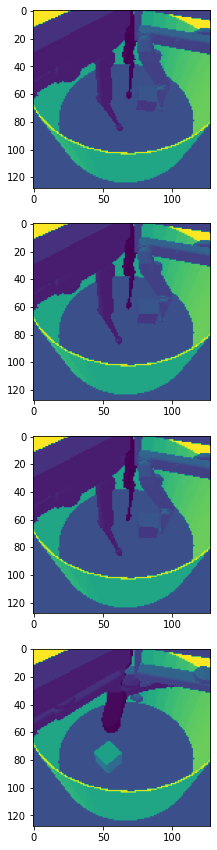

In [54]:

sample = obs[106]
plot_obs(sample, 1)

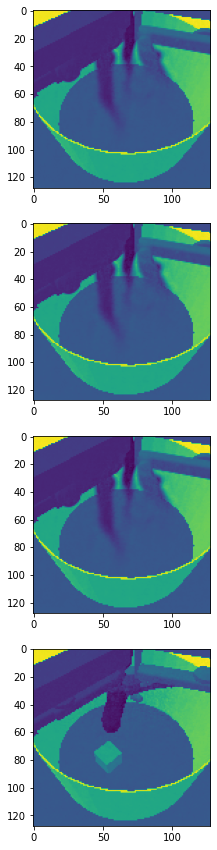

In [55]:
sample = torch.FloatTensor(sample) / 255.0
sample = sample.view(-1, 4, 128, 128)
z ,_, _ = encoder(sample.to(device))
recons = decoder(z)
recons = recons.detach().cpu().numpy()

plot_obs(recons, 1)